In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date
import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys


def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()

In [6]:
# Calculate MIZ width
filename = '/g/data/ia40/sea-ice-classification/kmean_2017.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']
n_days, n_lat, n_lon = ds['k'].shape
miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
miz_width_array = np.empty((n_days,n_lon))
effective_miz_width_array = np.empty((n_days,n_lon))
sic_width_array = np.empty((n_days,n_lon))

miz_upper_boundary = np.empty((n_days,n_lon))
miz_lower_boundary = np.empty((n_days,n_lon))


day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    for lon_idx in range(0,n_lon):
        # MIZ width
        miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
        sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
        miz_idx = miz_idx*sic_idx
        sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
        if not any(miz_idx):
            # If there are no MIZ cells then set distance to 0
            miz_width_array[day_idx,lon_idx] = 0
            effective_miz_width_array[day_idx,lon_idx] = 0
            
            
            miz_upper_boundary[day_idx,lon_idx] = LT[0,lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[0,lon_idx]
        else:
            miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
            effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()
            
            locs = np.asarray(miz_idx).nonzero()
            miz_upper_boundary[day_idx,lon_idx] = LT[locs[0][-1],lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[locs[0][0],lon_idx]
            
        if not any(sic_1580_idx):
            sic_width_array[day_idx,lon_idx] = 0
        else:
            sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()

Progress: [####################] 100% 


[31, 120, 243, 334]


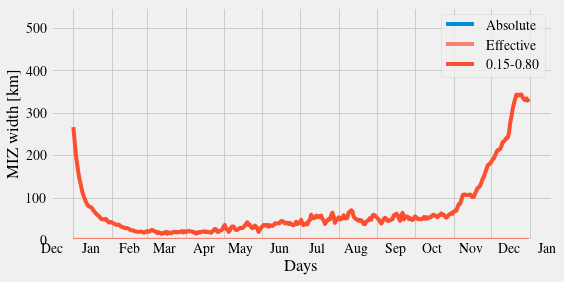

NameError: name 'savepath' is not defined

In [9]:
Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(0,365)
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
#ax.xaxis.set_major_locator(half_year_locator)
#ax.xaxis.set_minor_locator(monthly_locator)
#ax.xaxis.set_major_formatter(month_year_formatter)
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))#(1,2,3,4,5,6,7,8,9,10,11,12)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

brouwer_dates = [31,31+28+31+30,31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30+31+30]
print(brouwer_dates)

print(mdates.MonthLocator(bymonthday=15))

#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

line_deviation = 1 * (effective_miz_width_array[day_vec,:].std(axis=1)/1000)
mean = effective_miz_width_array[day_vec,:].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Absolute")
plt.plot(x_dates, mean, label = "Effective", color=Cmap[0,:])
#plt.plot(x_dates[brouwer_dates],[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")


plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)


#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
fig.savefig(savepath+'miz_width.png', dpi = 300) 


In [10]:
effective_miz_width_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])